In [1]:
!pip3 install jiwer
!pip3 install jieba
!pip install opencc-python-reimplemented
!pip install cn2an

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import jiwer
import jieba
import re
import opencc
import matplotlib.pyplot as plt
import cn2an
import seaborn as sns
from scipy import stats

## Construct dataframe


In [2]:
df_A_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/D00XX_A.csv', index_col=0, skipinitialspace=True)
df_B_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/D00XX_B.csv', index_col=0, skipinitialspace=True)
df_P_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/P00XX.csv', index_col=0, skipinitialspace=True)
df_A_cleaned['file'] = df_A_cleaned['file'].str.extract(r'/(D\d{4}_A)', expand=False)
df_B_cleaned['file'] = df_B_cleaned['file'].str.extract(r'/(D\d{4}_B)', expand=False)
df_P_cleaned['file'] = df_P_cleaned['file'].str.extract(r'/(P\d{4})', expand=False)

df_cleaned = pd.concat([df_A_cleaned, df_B_cleaned, df_P_cleaned])
df_cleaned['start_time'] = df_cleaned['start_time'].astype(float)
df_cleaned['end_time'] = df_cleaned['end_time'].astype(float)
df_cleaned = df_cleaned.drop(columns=['participant'])
df_cleaned = df_cleaned.drop_duplicates()

df_cleaned = df_cleaned.assign(ground_truth_cleaned=df_cleaned['ground_truth_cleaned'].apply(lambda x: re.sub(r"[，。]", "", x)))
df_cleaned = df_cleaned.assign(ground_truth_cleaned=df_cleaned['ground_truth_cleaned'].apply(lambda x: re.sub(r"<.*?>", "", x)))
    
df_model = pd.read_csv(f'/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Azure.csv', index_col=0, skipinitialspace=True)
df_model = df_model.rename(columns={'Filename': 'file', 'Start_time': 'start_time', 'End_time': 'end_time'})
df_model['start_time'] = df_model['start_time'].astype(float)
df_model['end_time'] = df_model['end_time'].astype(float)
df_model = df_model.drop_duplicates()

df_merged = pd.merge(df_cleaned, df_model, on=['file', 'start_time', 'end_time'], how='outer')

df_merged = df_merged[df_merged['ground_truth_cleaned'].apply(lambda x: isinstance(x, str))]
df_merged = df_merged[df_merged['Azure'].apply(lambda x: isinstance(x, str))]
# ground_truth_cleaned == ""    10+ pieces
df_merged = df_merged[df_merged['ground_truth_cleaned']!=""]

In [3]:
#ground_truth include English
# df_merged = df_merged.assign(include_english = df_merged['ground_truth_cleaned'].apply(lambda x: bool(re.search(r'\b[a-zA-Z]+\b', x))))
# data_english = df_merged[df_merged['include_english']==True]
# data_english.to_csv('english.csv')

In [4]:
#clean data for predicted transcription
#transfer from traditional to simple
converter = opencc.OpenCC('t2s')  
df_merged = df_merged.assign(Azure=df_merged['Azure'].apply(lambda x: converter.convert(x)))
#clean puactuation and transfer numbers
pattern  = r"[\s\W]"
df_merged = df_merged.assign(Azure = df_merged['Azure'].apply(lambda x: re.sub(pattern, "", x)))
df_merged = df_merged.assign(Azure = df_merged['Azure'].apply(lambda x: cn2an.transform(x, "an2cn")))

In [5]:
#ground_truth_cleaned_with_repetition 
mask_pattern = r"\<.*?\>"
annotation_pattern = r"/\w"

df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth'].apply(lambda x: re.sub(mask_pattern, "", x)))
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: re.sub(annotation_pattern, "", x)))

#transfer from traditional to simple
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: converter.convert(x)))
#clean puactuation and transfer numbers
pattern  = r"[\s\W]"
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition = df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: re.sub(pattern, "", x)))
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition = df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: cn2an.transform(x, "an2cn")))

In [6]:
df_merged

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Azure,ground_truth_cleaned_with_repetition
0,D0001_A,87.970,94.850,大/r[大]家好，我是叫<姓名>，那。,大家好我是叫那,大大大家好,大大家好我是叫那
1,D0001_A,95.580,102.830,我是，今年是，<年龄>岁来自<居住地>，呃/i。,我是今年是岁来自,我是今年是,我是今年是岁来自呃
2,D0001_A,104.090,105.680,我是。,我是,我是,我是
3,D0001_A,106.300,119.120,资深/p的口/b[口/r/b]吃患者。,资深的口吃患者,那个资深的,资深的口口吃患者
4,D0001_A,119.130,124.490,我是从小就有口吃。,我是从小就有口吃,我是从小就有口吃,我是从小就有口吃
...,...,...,...,...,...,...,...
37245,P0070,3032.636,3035.926,你好，米雅，拿日元换法郎怎么换。,你好米雅拿日元换法郎怎么换,你好米亚拿日元换发廊怎么换,你好米雅拿日元换法郎怎么换
37246,P0070,3037.766,3041.436,你好，米雅，六百五十韩元是多少法郎。,你好米雅六百五十韩元是多少法郎,你好米亚六百五十韩元是多少法郎,你好米雅六百五十韩元是多少法郎
37247,P0070,3043.086,3045.546,你好，米雅，添加日程。,你好米雅添加日程,你好米亚添加日程,你好米雅添加日程
37248,P0070,3049.256,3053.116,我觉得推翻现有数学体系不是那么不可思议了。,我觉得推翻现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了


In [20]:
# df_merged_a = df_merged[df_merged['Whisper_large'].apply(lambda x: isinstance(x, float))]
# df_merged_a
# df_merged_b = df_merged[df_merged['ground_truth_cleaned'].apply(lambda x: isinstance(x, float))]
# df_merged_b

In [7]:
#without repetition
#word/character error rate
WER = []
CER = []
#word/character error count
# WEC = []
# CEC = []

for i in range(df_merged.shape[0]):
    reference = df_merged['ground_truth_cleaned'].iloc[i]
    hypothesis = df_merged['Azure'].iloc[i]
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        WER.append(np.nan)
        CER.append(np.nan)
    else:
#         print(' '.join(jieba.lcut(reference)),"COMPARE", ' '.join(jieba.lcut(hypothesis)))
#         print(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
#         print(jiwer.cer(reference, hypothesis))
        WER.append(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
        CER.append(jiwer.cer(reference, hypothesis))

df_merged['WER'] = WER
df_merged['CER'] = CER

#with repetition
#word/character error rate
WER = []
CER = []
#word/character error count
# WEC = []
# CEC = []

for i in range(df_merged.shape[0]):
    reference = df_merged['ground_truth_cleaned_with_repetition'].iloc[i]
    hypothesis = df_merged['Azure'].iloc[i]
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        WER.append(np.nan)
        CER.append(np.nan)
    else:
#         print(' '.join(jieba.lcut(reference)),"COMPARE", ' '.join(jieba.lcut(hypothesis)))
#         print(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
#         print(jiwer.cer(reference, hypothesis))
        WER.append(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
        CER.append(jiwer.cer(reference, hypothesis))

df_merged['WER_repetition'] = WER
df_merged['CER_repetition'] = CER

Building prefix dict from the default dictionary ...
Dumping model to file cache /scratch/1407865.1.academic-gpu/jieba.cache
Loading model cost 0.565 seconds.
Prefix dict has been built successfully.


In [8]:
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"

df_merged = df_merged.assign(stutterance_count=df_merged['ground_truth'].apply(lambda x: len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))
df_merged = df_merged.assign(character_count=df_merged['ground_truth_cleaned'].apply(lambda x: len(x)))
df_merged = df_merged.assign(character_count_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: len(x)))
df_merged['stutterance_frequency'] = df_merged['stutterance_count']/df_merged['character_count']

In [9]:
df_merged['duration'] = df_merged['end_time']-df_merged['start_time']

In [10]:
#delete data with mask
# df_merged = df_merged.assign(mask = df_merged['ground_truth'].apply(lambda x: bool(re.search(r'<[^<>]*[\u4e00-\u9fff]+[^<>]*>', x))))
# df_merged = df_merged[df_merged['mask']==False]
# df_merged = df_merged.drop('mask', axis=1)

In [11]:
df_merged

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Azure,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
0,D0001_A,87.970,94.850,大/r[大]家好，我是叫<姓名>，那。,大家好我是叫那,大大大家好,大大家好我是叫那,0.833333,0.857143,0.714286,0.625000,2,7,8,0.285714,6.88
1,D0001_A,95.580,102.830,我是，今年是，<年龄>岁来自<居住地>，呃/i。,我是今年是岁来自,我是今年是,我是今年是岁来自呃,0.333333,0.375000,0.428571,0.444444,1,8,9,0.125000,7.25
2,D0001_A,104.090,105.680,我是。,我是,我是,我是,0.000000,0.000000,0.000000,0.000000,0,2,2,0.000000,1.59
3,D0001_A,106.300,119.120,资深/p的口/b[口/r/b]吃患者。,资深的口吃患者,那个资深的,资深的口口吃患者,0.750000,0.857143,0.800000,0.875000,5,7,8,0.714286,12.82
4,D0001_A,119.130,124.490,我是从小就有口吃。,我是从小就有口吃,我是从小就有口吃,我是从小就有口吃,0.000000,0.000000,0.000000,0.000000,0,8,8,0.000000,5.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37245,P0070,3032.636,3035.926,你好，米雅，拿日元换法郎怎么换。,你好米雅拿日元换法郎怎么换,你好米亚拿日元换发廊怎么换,你好米雅拿日元换法郎怎么换,0.250000,0.230769,0.250000,0.230769,0,13,13,0.000000,3.29
37246,P0070,3037.766,3041.436,你好，米雅，六百五十韩元是多少法郎。,你好米雅六百五十韩元是多少法郎,你好米亚六百五十韩元是多少法郎,你好米雅六百五十韩元是多少法郎,0.142857,0.066667,0.142857,0.066667,0,15,15,0.000000,3.67
37247,P0070,3043.086,3045.546,你好，米雅，添加日程。,你好米雅添加日程,你好米亚添加日程,你好米雅添加日程,0.250000,0.125000,0.250000,0.125000,0,8,8,0.000000,2.46
37248,P0070,3049.256,3053.116,我觉得推翻现有数学体系不是那么不可思议了。,我觉得推翻现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了,0.000000,0.000000,0.000000,0.000000,0,20,20,0.000000,3.86


In [12]:
df_merged.to_csv('Azure_evaluation.csv')

## Analysis

In [2]:
data = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/Azure_evaluation.csv', index_col=0)

In [14]:
data.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
count,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000,36753.000000
mean,1977.665808,1982.461574,0.278762,0.202053,0.202618,0.153214,1.017278,15.015237,15.832177,0.070548,4.795765
std,1025.568520,1023.728564,0.410257,0.304025,0.318557,0.254922,1.707050,13.693983,14.470570,0.159936,3.745691
min,0.490000,0.840000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.220000
25%,1129.090000,1136.900000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,1.960000
50%,2111.060000,2114.111000,0.142857,0.090909,0.043478,0.027778,0.000000,10.000000,10.000000,0.000000,3.380000
75%,2770.612000,2774.140000,0.411765,0.272727,0.300000,0.200000,1.000000,21.000000,22.000000,0.085714,6.860000
max,4157.869000,4168.639000,11.000000,8.000000,5.000000,6.000000,17.000000,118.000000,126.000000,5.000000,32.330000


### Overall Analysis 

In [15]:
#find outliers manually
data[data['WER']>3]
data[data['CER']>3]
# data = data[data['Whisper_large'].str.contains('转发打赏')!=True]
# data = data[data['Whisper_large'].str.contains('中文字幕')!=True]
#deleted mask data
#mask 在structure里删除了
#8535	D0062_A	39.210	42.990 mask需手动删除
#786	D0006_A	1571.400000	1571.920 无特殊问题
#21617	P0019	2929.924000	2930.744 无特殊问题
#6648	D0048_A	1387.060	1387.950 音频有一些截断问题？不算
#8032	D0057_A	1735.290	1736.820 无特殊问题

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Azure,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
1147,D0010_A,385.460,387.210,好[好好好]。,好,哈哈哈哈,好好好好,1.000000,4.000000,1.000000,1.000000,1,1,4,1.000000,1.75
1198,D0010_A,1291.240,1292.510,对/r[对对对对]。,对,对对对对对,对对对对对,4.000000,4.000000,0.000000,0.000000,2,1,5,2.000000,1.27
1216,D0010_A,1505.880,1507.720,<overlap>对[对对对]。,对,然后对对对对,对对对对,4.000000,5.000000,0.250000,0.500000,1,1,4,1.000000,1.84
3405,D0027_A,944.500,945.590,能[能能能]。,能,Nononono,能能能能,1.000000,8.000000,1.000000,2.000000,1,1,4,1.000000,1.09
4046,D0031_A,611.160,612.620,嗯/p<overlap>。,嗯,嗯跟你一样,嗯,3.000000,4.000000,3.000000,4.000000,1,1,1,1.000000,1.46
6035,D0043_A,1096.010,1101.620,我[我]跟他们说我[我我我我我/b我/b我/b我/b]要开会。,我跟他们说我要开会,我我跟他们说我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我我...,我我跟他们说我我我我我我我我我要开会,9.428571,7.333333,3.562500,3.166667,6,9,18,0.666667,5.61
8364,D0060_A,562.080,562.610,对。,对,Thanuh,对,1.000000,6.000000,1.000000,6.000000,0,1,1,0.000000,0.53
10855,D0013_B,1240.810,1243.370,的/p/b<overlap>嗯/i。,的,我就是我嗯,的嗯,4.000000,5.000000,1.500000,2.000000,3,1,2,3.000000,2.56
12991,D0042_B,775.150,775.680,嗯。,嗯,Yeah,嗯,1.000000,4.000000,1.000000,4.000000,0,1,1,0.000000,0.53
14438,D0060_B,306.810,307.690,嗯/p。,嗯,Umuh,嗯,1.000000,4.000000,1.000000,4.000000,1,1,1,1.000000,0.88


In [16]:
data = data.assign(z_scores = data['CER'].apply(lambda x: (x-data['CER'].mean())/data['CER'].std()))
data_normal = data[data['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['WER'].apply(lambda x: (x-data_normal['WER'].mean())/data_normal['WER'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['WER_repetition'].apply(lambda x: (x-data_normal['WER_repetition'].mean())/data_normal['WER_repetition'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['CER_repetition'].apply(lambda x: (x-data_normal['CER_repetition'].mean())/data_normal['CER_repetition'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_outliers = data[~data.index.isin(data_normal.index)]
data.drop('z_scores', axis=1)
data_outliers

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Azure,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores
3,D0001_A,106.30000,119.120,资深/p的口/b[口/r/b]吃患者。,资深的口吃患者,那个资深的,资深的口口吃患者,0.750000,0.857143,0.800000,0.875000,5,7,8,0.714286,12.82000,2.154721
14,D0001_A,238.68000,254.120,呃/i我在工作的时候就，嗯/i/b就我讲课讲着讲着就会卡/r/b了。,我在工作的时候就就我讲课讲着讲着就会卡了,呃我,呃我在工作的时候就嗯就我讲课讲着讲着就会卡了,0.941176,0.950000,0.894737,0.909091,5,20,22,0.250000,15.44000,2.460147
15,D0001_A,254.41000,274.320,然后就/b孩子就会看/b着我，他[他]们就会觉得，哎老师/b你怎么卡了，就/r[就]怎么不/...,然后就孩子就会看着我他们就会觉得哎老师你怎么卡了就怎么不说话了,然后就,然后就孩子就会看着我他他们就会觉得哎老师你怎么卡了就就怎么不说话了,0.909091,0.903226,0.916667,0.909091,7,31,33,0.225806,19.91000,2.306297
36,D0001_A,642.62000,659.650,有的家长就不/b是，那么有，就是能理解，那[那]些不能理解的家长，他[他]可能就会放/b大我...,有的家长就不是那么有就是能理解那些不能理解的家长他可能就会放大我这件事情,有的家长就,有的家长就不是那么有就是能理解那那些不能理解的家长他他可能就会放大我这件事情,0.826087,0.861111,0.840000,0.868421,4,36,38,0.111111,17.03000,2.167773
62,D0001_A,1080.61818,1110.200,画/p面对嗯，嗯/i/p然后呃/i最近呢呃/i/p这两天呢我还看了一部就是释/r小龙，他那个...,画面对嗯然后最近呢这两天呢我还看了一部就是释小龙他那个刚上映的那部电影叫逃学神探对,画面对嗯嗯,画面对嗯嗯然后呃最近呢呃这两天呢我还看了一部就是释小龙他那个刚上映的那那部电影叫逃学神探对,0.888889,0.902439,0.870968,0.888889,11,41,45,0.268293,29.58182,2.303709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36299,P0066,2585.77200,2591.272,你[你]好米[米]雅，旁[旁旁]边酒店。,你好米雅旁边酒店,你你好你你呀旁旁旁边酒店,你你好米米雅旁旁旁边酒店,1.500000,0.750000,0.500000,0.250000,3,8,12,0.375000,5.50000,1.802307
36308,P0066,2660.55200,2670.662,你[你]好米雅，接通韩/p[接通韩/p接通韩]梅梅的电话。,你好米雅接通韩梅梅的电话,你你好你呀,你你好米雅接通韩接通韩接通韩梅梅的电话,1.000000,0.916667,0.818182,0.842105,4,12,19,0.333333,10.11000,2.350507
36849,P0069,1731.32000,1735.020,导航力高景力/r高悦景。,导航力高景力高悦景,导航立高井立高预警,导航力高景力高悦景,1.333333,0.555556,1.333333,0.555556,1,9,9,0.111111,3.70000,1.162740
37011,P0070,2086.68600,2087.556,制热。,制热,致乐,制热,1.000000,1.000000,1.000000,1.000000,0,2,2,0.000000,0.87000,2.624607


In [17]:
data_outliers.to_csv('outliers_azure.csv')

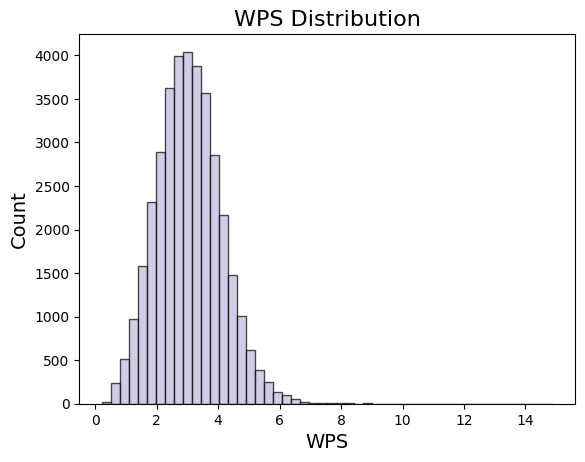

In [18]:
#speed
data['WPS'] = data['character_count']/data['duration']
plt.hist(data['WPS'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("WPS Distribution", fontsize=16)
plt.xlabel("WPS", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

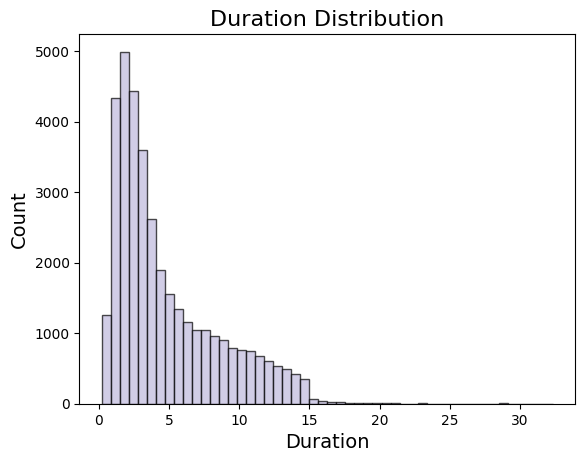

In [19]:
#duration
plt.hist(data['duration'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Duration Distribution", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [20]:
#correlation
data_number = data[['WER','CER','WER_repetition','CER_repetition','stutterance_count','character_count','character_count_repetition','stutterance_frequency','duration', 'WPS']]
data_cor_spearman = data_number.corr(method="spearman")
data_cor_pearson = data_number.corr()

In [21]:
data_cor_pearson

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.841112,0.780333,0.675558,0.301657,-0.061461,-0.021704,0.517708,0.098057,-0.268042
CER,0.841112,1.000000,0.746332,0.862344,0.334142,-0.016355,0.024765,0.513021,0.166254,-0.282711
WER_repetition,0.780333,0.746332,1.000000,0.853522,0.131173,-0.059588,-0.047348,0.202392,0.067721,-0.156079
CER_repetition,0.675558,0.862344,0.853522,1.000000,0.187038,-0.013974,0.000767,0.225300,0.143678,-0.197748
stutterance_count,0.301657,0.334142,0.131173,0.187038,1.000000,0.466932,0.539282,0.615677,0.677529,-0.167179
character_count,-0.061461,-0.016355,-0.059588,-0.013974,0.466932,1.000000,0.993316,-0.019184,0.895080,0.424539
character_count_repetition,-0.021704,0.024765,-0.047348,0.000767,0.539282,0.993316,1.000000,0.040995,0.913762,0.384645
stutterance_frequency,0.517708,0.513021,0.202392,0.225300,0.615677,-0.019184,0.040995,1.000000,0.198401,-0.407267
duration,0.098057,0.166254,0.067721,0.143678,0.677529,0.895080,0.913762,0.198401,1.000000,0.083581
WPS,-0.268042,-0.282711,-0.156079,-0.197748,-0.167179,0.424539,0.384645,-0.407267,0.083581,1.000000


In [22]:
data_cor_spearman

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.972225,0.853883,0.838453,0.447059,0.208393,0.259063,0.481897,0.326068,-0.151252
CER,0.972225,1.000000,0.853442,0.871356,0.469876,0.241999,0.293524,0.494287,0.360618,-0.144079
WER_repetition,0.853883,0.853442,1.000000,0.984829,0.240331,0.202644,0.223104,0.236422,0.270165,-0.064495
CER_repetition,0.838453,0.871356,0.984829,1.000000,0.258851,0.222363,0.243412,0.251081,0.292937,-0.065716
stutterance_count,0.447059,0.469876,0.240331,0.258851,1.000000,0.533397,0.602302,0.954072,0.692280,-0.115891
character_count,0.208393,0.241999,0.202644,0.222363,0.533397,1.000000,0.990117,0.368672,0.902916,0.480245
character_count_repetition,0.259063,0.293524,0.223104,0.243412,0.602302,0.990117,1.000000,0.449486,0.926704,0.428069
stutterance_frequency,0.481897,0.494287,0.236422,0.251081,0.954072,0.368672,0.449486,1.000000,0.568283,-0.243329
duration,0.326068,0.360618,0.270165,0.292937,0.692280,0.902916,0.926704,0.568283,1.000000,0.101315
WPS,-0.151252,-0.144079,-0.064495,-0.065716,-0.115891,0.480245,0.428069,-0.243329,0.101315,1.000000


### Stutter VS non-Stutter

In [3]:
data_stutter = data[data['stutterance_count']>0]
data_non_stutter = data[data['stutterance_count']==0]

In [24]:
data_stutter.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores,WPS
count,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000,14986.000000
mean,1452.017302,1459.675075,0.415671,0.309180,0.237091,0.194369,2.494862,23.338916,25.414787,0.173018,7.657773,0.352362,2.904688
std,972.345677,970.939249,0.483967,0.353927,0.308598,0.272301,1.860179,15.453590,15.972908,0.212146,3.807606,1.164138,1.073530
min,0.490000,6.210000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.011628,0.480000,-0.664593,0.216920
25%,642.822500,653.055000,0.125000,0.083333,0.000000,0.000000,1.000000,10.000000,12.000000,0.062500,4.540000,-0.390493,2.094728
50%,1295.380000,1305.525000,0.272727,0.187500,0.105263,0.066667,2.000000,21.000000,23.000000,0.111111,7.330000,-0.047868,2.936631
75%,2170.543000,2175.204000,0.571429,0.444444,0.357143,0.263158,3.000000,34.000000,37.000000,0.200000,10.500000,0.797274,3.680000
max,4157.869000,4168.639000,11.000000,8.000000,3.562500,4.000000,17.000000,118.000000,126.000000,5.000000,32.330000,25.649004,7.976366


In [25]:
data_non_stutter.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores,WPS
count,21767.000000,21767.000000,21767.000000,21767.000000,21767.000000,21767.000000,21767.0,21767.000000,21767.000000,21767.0,21767.000000,21767.000000,21767.000000
mean,2339.560811,2342.386160,0.184504,0.128299,0.178884,0.124880,0.0,9.284605,9.234805,0.0,2.825349,-0.242592,3.170538
std,896.567825,896.011764,0.318040,0.237676,0.323112,0.238141,0.0,8.466412,8.436179,0.0,2.046107,0.781765,1.026285
min,0.500000,0.840000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.0,0.220000,-0.664593,0.494234
25%,1874.375000,1877.807000,0.000000,0.000000,0.000000,0.000000,0.0,4.000000,4.000000,0.0,1.510000,-0.664593,2.453988
50%,2430.806000,2433.498000,0.000000,0.000000,0.000000,0.000000,0.0,7.000000,7.000000,0.0,2.310000,-0.664593,3.076923
75%,2988.993000,2991.813500,0.250000,0.166667,0.250000,0.166667,0.0,11.000000,11.000000,0.0,3.410000,-0.116393,3.773585
max,4153.299000,4157.799000,5.000000,6.000000,5.000000,6.000000,0.0,79.000000,79.000000,0.0,20.070000,19.070605,14.893617


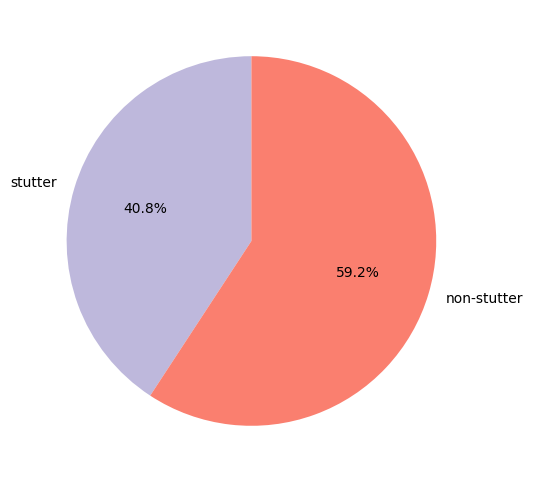

In [12]:
labels = ['stutter', 'non-stutter']
sizes = [14986, 21767]  # 各类别的比例
colors = ['#BEB8DC', '#FA7F6F']  # 自定义颜色
# explode = (0, 0.1)  # 突出显示某一部分 (如第二块)

# 绘制饼状图
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
# plt.title('Pie Chart Example')
plt.show()

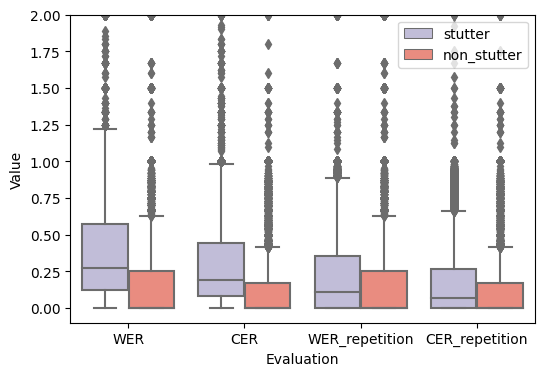

In [40]:
data_stutter_number = data_stutter[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_stutter_number['Group'] = 'stutter'
data_non_stutter_number = data_non_stutter[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_number['Group'] = 'non_stutter'
combined_data = pd.concat([data_stutter_number, data_non_stutter_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F']
sns.boxplot(data=combined_data, x='Evaluation', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 2) 
plt.title("")
plt.legend()
plt.show()

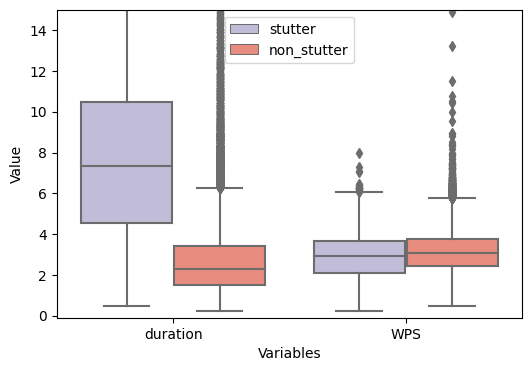

In [41]:
data_stutter_number = data_stutter[['duration', 'WPS']].melt(var_name='Variables', value_name='Value')
data_stutter_number['Group'] = 'stutter'
data_non_stutter_number = data_non_stutter[['duration', 'WPS']].melt(var_name='Variables', value_name='Value')
data_non_stutter_number['Group'] = 'non_stutter'
combined_data = pd.concat([data_stutter_number, data_non_stutter_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F']
sns.boxplot(data=combined_data, x='Variables', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 15) 
plt.title("")
plt.legend()
plt.show()

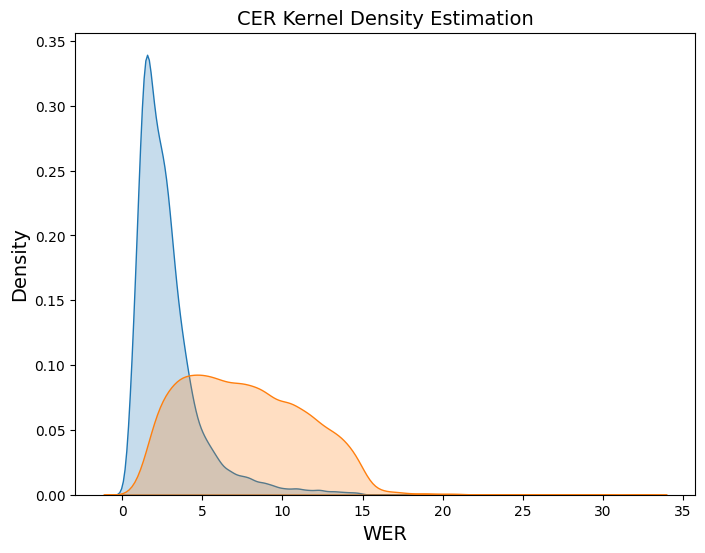

In [7]:
#CER
plt.figure(figsize=(8, 6))
sns.kdeplot(data_non_stutter['duration'], label='non_stutter', fill=True)
sns.kdeplot(data_stutter['duration'], label='stutter', fill=True)

plt.title("CER Kernel Density Estimation", fontsize=14)
# plt.xlim(-1,3)
plt.xlabel('WER', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

### non-Stutter

In [43]:
#non-stutter data
data_non_stutter_number = data_non_stutter[['WER','CER','WER_repetition','CER_repetition','character_count','character_count_repetition','duration', 'WPS']]
data_non_stutter_cor_pearson = data_non_stutter_number.corr()
data_non_stutter_cor_spearman = data_non_stutter_number.corr(method = 'spearman')

In [44]:
data_non_stutter_cor_pearson

,WER,CER,WER_repetition,CER_repetition,character_count,character_count_repetition,duration,WPS
WER,1.000000,0.825586,0.978415,0.813381,-0.032656,-0.037526,0.006327,0.017787
CER,0.825586,1.000000,0.815845,0.995033,-0.013511,-0.017249,0.042037,-0.013668
WER_repetition,0.978415,0.815845,1.000000,0.816018,-0.035920,-0.038115,0.003933,0.016087
CER_repetition,0.813381,0.995033,0.816018,1.000000,-0.016561,-0.018193,0.041680,-0.024497
character_count,-0.032656,-0.013511,-0.035920,-0.016561,1.000000,0.999521,0.914749,0.454115
character_count_repetition,-0.037526,-0.017249,-0.038115,-0.018193,0.999521,1.000000,0.915354,0.449764
duration,0.006327,0.042037,0.003933,0.041680,0.914749,0.915354,1.000000,0.155601
WPS,0.017787,-0.013668,0.016087,-0.024497,0.454115,0.449764,0.155601,1.000000


In [45]:
data_non_stutter_cor_spearman

,WER,CER,WER_repetition,CER_repetition,character_count,character_count_repetition,duration,WPS
WER,1.000000,0.983259,0.972800,0.957340,0.239952,0.230213,0.202191,0.123425
CER,0.983259,1.000000,0.963439,0.978942,0.250667,0.241977,0.212612,0.126981
WER_repetition,0.972800,0.963439,1.000000,0.984741,0.232636,0.230424,0.203830,0.106358
CER_repetition,0.957340,0.978942,0.984741,1.000000,0.242284,0.240167,0.212867,0.109854
character_count,0.239952,0.250667,0.232636,0.242284,1.000000,0.998869,0.887353,0.548316
character_count_repetition,0.230213,0.241977,0.230424,0.240167,0.998869,1.000000,0.889041,0.543806
duration,0.202191,0.212612,0.203830,0.212867,0.887353,0.889041,1.000000,0.147364
WPS,0.123425,0.126981,0.106358,0.109854,0.548316,0.543806,0.147364,1.000000


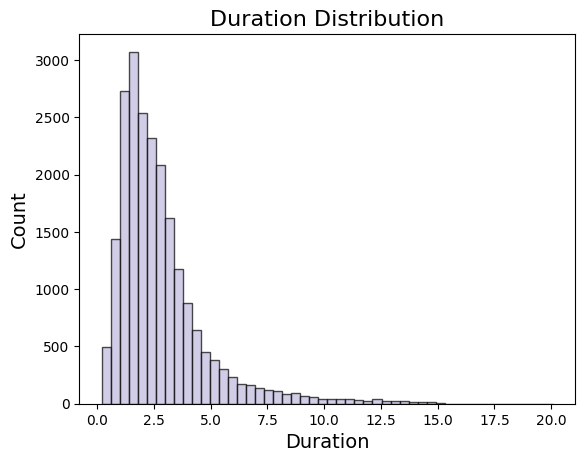

count    21767.000000
mean         2.825349
std          2.046107
min          0.220000
25%          1.510000
50%          2.310000
75%          3.410000
max         20.070000
Name: duration, dtype: float64

In [46]:
#duration
plt.hist(data_non_stutter['duration'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Duration Distribution", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

data_non_stutter['duration'].describe()

In [47]:
data_non_stutter_long = data_non_stutter[data_non_stutter['duration'] > 7.5]
data_non_stutter_medium = data_non_stutter[data_non_stutter['duration'] > 3.38]
data_non_stutter_medium = data_non_stutter_medium[data_non_stutter_medium['duration'] <= 7.5]
data_non_stutter_short = data_non_stutter[data_non_stutter['duration']<=3.38]

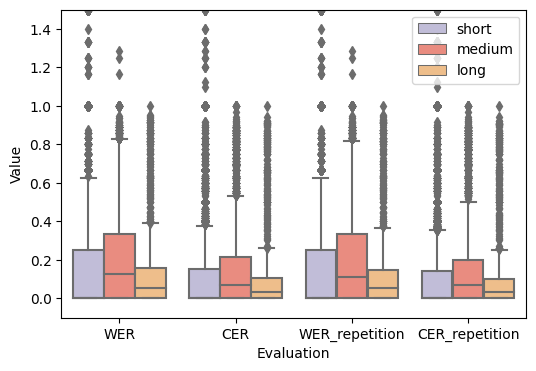

In [48]:
data_non_stutter_long_number = data_non_stutter_long[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_long_number['Group'] = 'long'
data_non_stutter_medium_number = data_non_stutter_medium[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_medium_number['Group'] = 'medium'
data_non_stutter_short_number = data_non_stutter_short[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_short_number['Group'] = 'short'
combined_data = pd.concat([data_non_stutter_short_number,data_non_stutter_medium_number, data_non_stutter_long_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F', "#FFBE7A"]
sns.boxplot(data=combined_data, x='Evaluation', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 1.5) 
plt.title("")
plt.legend()
plt.show()

### Stutter

In [49]:
data_stutter_number = data_stutter[['WER','CER','WER_repetition','CER_repetition','stutterance_count','character_count','character_count_repetition','stutterance_frequency','duration', 'WPS']]
data_stutter_cor_spearman = data_stutter_number.corr(method='spearman')
data_stutter_cor_pearson = data_stutter_number.corr()

In [50]:
data_stutter_cor_spearman

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.947924,0.680937,0.664110,0.240146,-0.401603,-0.339456,0.546456,-0.155102,-0.537179
CER,0.947924,1.000000,0.724818,0.740118,0.276676,-0.335693,-0.269869,0.505312,-0.077111,-0.510136
WER_repetition,0.680937,0.724818,1.000000,0.981915,0.186433,-0.101032,-0.081593,0.205820,0.103026,-0.291965
CER_repetition,0.664110,0.740118,0.981915,1.000000,0.202824,-0.077598,-0.057919,0.195786,0.132246,-0.285775
stutterance_count,0.240146,0.276676,0.186433,0.202824,1.000000,0.287664,0.362589,0.443436,0.506564,-0.107439
character_count,-0.401603,-0.335693,-0.101032,-0.077598,0.287664,1.000000,0.988742,-0.690793,0.861182,0.728019
character_count_repetition,-0.339456,-0.269869,-0.081593,-0.057919,0.362589,0.988742,1.000000,-0.626067,0.881358,0.688246
stutterance_frequency,0.546456,0.505312,0.205820,0.195786,0.443436,-0.690793,-0.626067,1.000000,-0.406357,-0.757570
duration,-0.155102,-0.077111,0.103026,0.132246,0.506564,0.861182,0.881358,-0.406357,1.000000,0.313520
WPS,-0.537179,-0.510136,-0.291965,-0.285775,-0.107439,0.728019,0.688246,-0.757570,0.313520,1.000000


In [51]:
data_stutter_cor_pearson

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.828365,0.643496,0.563685,0.196097,-0.353445,-0.308537,0.580721,-0.161749,-0.493265
CER,0.828365,1.000000,0.732783,0.774753,0.240035,-0.298606,-0.250470,0.567961,-0.061642,-0.497026
WER_repetition,0.643496,0.732783,1.000000,0.909124,0.154925,-0.205355,-0.191147,0.295187,0.023664,-0.383655
CER_repetition,0.563685,0.774753,0.909124,1.000000,0.191376,-0.154369,-0.139308,0.266721,0.104246,-0.378567
stutterance_count,0.196097,0.240035,0.154925,0.191376,1.000000,0.208809,0.294921,0.396812,0.491927,-0.172675
character_count,-0.353445,-0.298606,-0.205355,-0.154369,0.208809,1.000000,0.990015,-0.470743,0.838852,0.693731
character_count_repetition,-0.308537,-0.250470,-0.191147,-0.139308,0.294921,0.990015,1.000000,-0.420640,0.858474,0.657757
stutterance_frequency,0.580721,0.567961,0.295187,0.266721,0.396812,-0.470743,-0.420640,1.000000,-0.252183,-0.619659
duration,-0.161749,-0.061642,0.023664,0.104246,0.491927,0.838852,0.858474,-0.252183,1.000000,0.268018
WPS,-0.493265,-0.497026,-0.383655,-0.378567,-0.172675,0.693731,0.657757,-0.619659,0.268018,1.000000


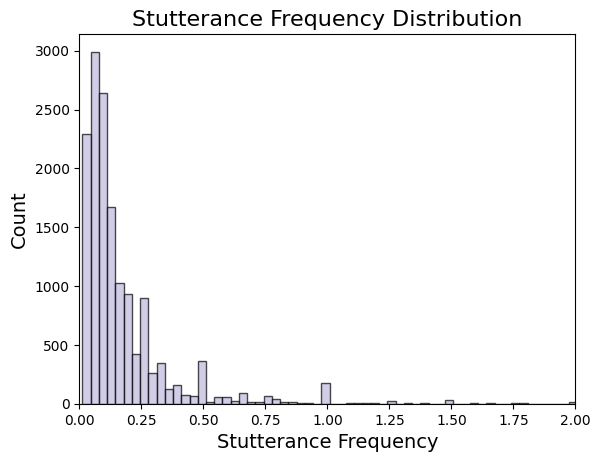

In [52]:
#stutterance frequency
plt.hist(data_stutter['stutterance_frequency'], bins = 150, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Stutterance Frequency Distribution", fontsize=16)
plt.xlim(-0, 2)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

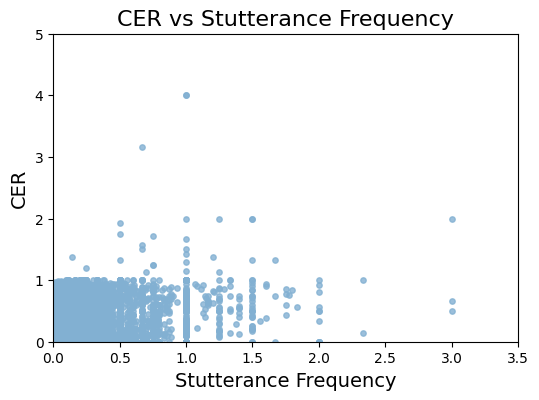

In [4]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data_stutter["stutterance_frequency"], 
    data_stutter["WER_repetition"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,3.5)
plt.ylim(0,5)

plt.title("CER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("CER", fontsize=14)
# plt.grid(True)
plt.show()

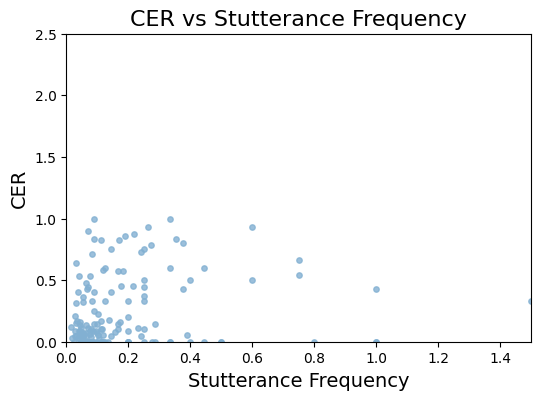

In [6]:
sampled_data_stutter = data_stutter.groupby('file').sample(frac=0.01, random_state=42)
plt.figure(figsize=(6, 4))
plt.scatter(
    sampled_data_stutter["stutterance_frequency"], 
    sampled_data_stutter["WER_repetition"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,1.5)
plt.ylim(0,2.5)

plt.title("CER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("CER", fontsize=14)
# plt.grid(True)
plt.show()

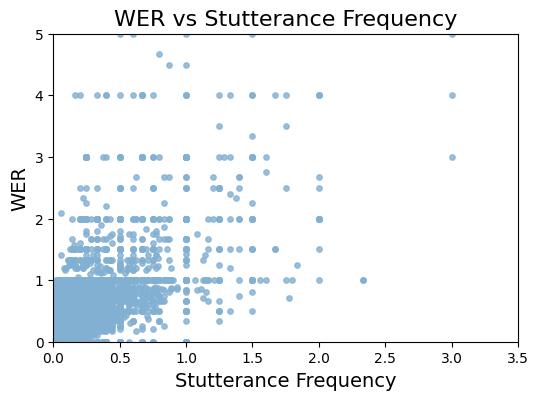

In [58]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data_stutter["stutterance_frequency"], 
    data_stutter["WER"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,3.5)
plt.ylim(0,5)

plt.title("WER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("WER", fontsize=14)
# plt.grid(True)
plt.show()

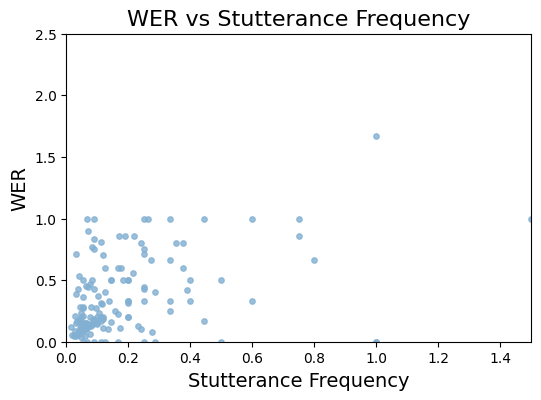

In [59]:
sampled_data_stutter = data_stutter.groupby('file').sample(frac=0.01, random_state=42)
plt.figure(figsize=(6, 4))
plt.scatter(
    sampled_data_stutter["stutterance_frequency"], 
    sampled_data_stutter["WER"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,1.5)
plt.ylim(0,2.5)

plt.title("WER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("WER", fontsize=14)
# plt.grid(True)
plt.show()

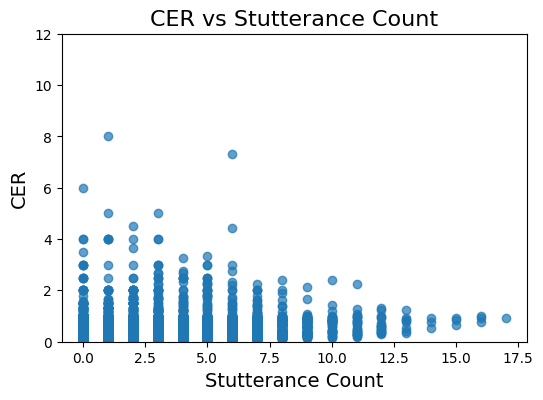

In [60]:
#stutterance count
plt.figure(figsize=(6, 4))
plt.scatter(
    data["stutterance_count"], 
    data["CER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("CER vs Stutterance Count", fontsize=16)
plt.ylim(0,12)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("CER", fontsize=14)
plt.show()

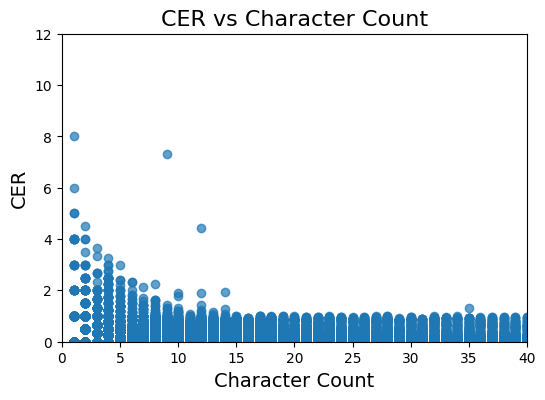

In [61]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data["character_count"], 
    data["CER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("CER vs Character Count", fontsize=16)
plt.xlim(0,40)
plt.ylim(0,12)
plt.xlabel("Character Count", fontsize=14)
plt.ylabel("CER", fontsize=14)
plt.show()